# ICA e PCA - dettagli

Prendendo spunto da quanto fatto da [A.K.Carsten](https://github.com/akcarsten/Independent_Component_Analysis) si discutono alcuni dettagli dell'algoritmo ICA,[^hyvarinen-ica] applicandolo a un problema di riconoscimento delle componenti indipendenti di segnali in tempo.

In particolare, si vuole discutere **todo**:
- i dettagli dell'algoritmo, prestando attenzione a
  - la relazione "non-gaussianità" $\sim$ "indipendenza"
  - la misura di non gaussianità tramite neg-entropia, e le sue approssimazioni
  - l'espressione dell'iterazione di Newton nell'ottimizzazione della neg-entropia, che dà vita a un problema di punto fisso
- la necessità della non-gaussianità dei segnali


[^hyvarinen-ica]: A.Hyvarinen, E.Oja *Independent component analysis: algorithms and applications"


## Librerie e funzioni utili

In [8]:
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt

## Generazione segnale

Viene generato un campione test con 200 campioni di 3 osservazioni, come risultato del mix di 3 segnali indipendenti, da ricostruire con l'algoritmo ICA.

In [123]:
# Set a seed for the random number generator for reproducibility
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

noise_ampl = .2
noise_avg  = .0

# Source matrix
S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              noise_ampl*( np.random.random(len(ns)) - .5) + noise_avg ]).T

# Mixing matrix
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signal matrix
X = S.dot(A).T

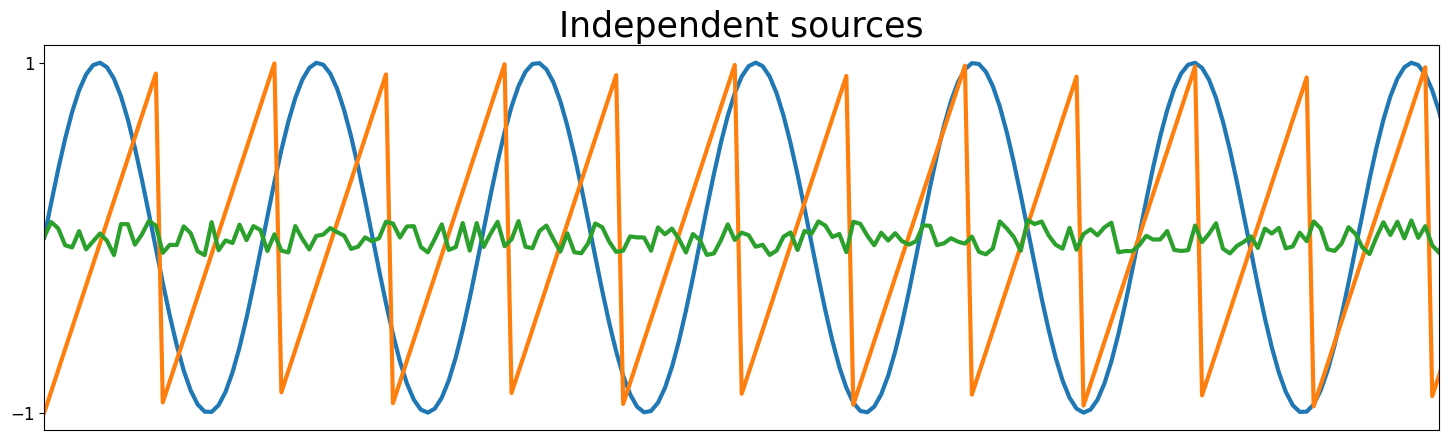

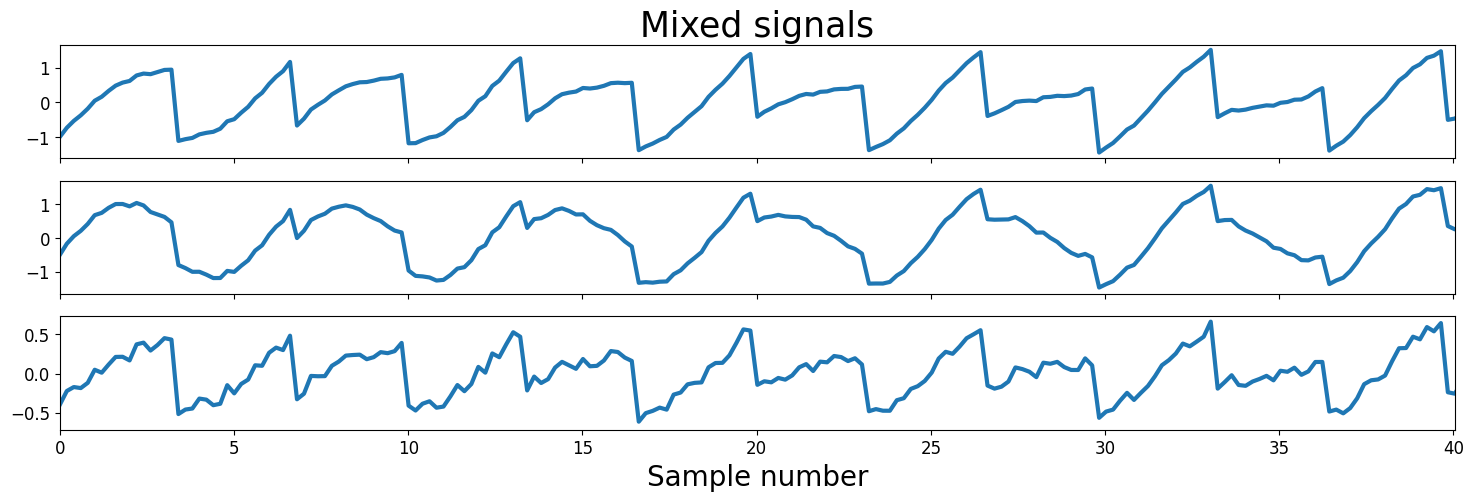

In [124]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=3)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=3)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=3)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=3)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()


## Algoritmo


### Pre-processing

L'osservazione $\mathbf{X}$ vengono **depurate dalla media** e viene usata una trasformazione per combinare le osservazioni originali e ottenere un nuovo segnale $\mathbf{X}_w$ con **componenti non correlate**. Il procedimento viene illustrato per i dati organizzati nella matrice,

$$\mathbf{X} = \begin{bmatrix} \mathbf{x}_1 | \mathbf{x}_2 | \dots | \mathbf{x}_{s} \end{bmatrix} \ ,$$

in cui la colonna $j$-esima contiene le $n_x$ osservazioni relative all'indice $j$ (istante di tempo, paziente,...), mentre la riga $i$-esima contiene l'osservazione della quantità identificata dall'indice $i$ per ogni valore di $j$ (istante di tempo, paziente,...).



```{dropdown} Teoria

Vengono svolte due operazioni:

- rimozione della media dalle osservazioni di ogni quantità, quindi rimozione del valore medio di ogni riga,
  $$X_{ij} \quad \leftarrow \quad X_{ij} - \frac{1}{n_s} \sum_{j = 1}^{n_s} X_{ij} \ ,$$
  in modo da avere i nuovi segnali a media nulla;

- ricerca di una trasformazione di coordinate (combinazione delle osservazioni) che renda la nuove componenti non correlate. Una stima senza bias della correlazione è

  $$\hat{\mathbf{R}} = \frac{1}{n_s - 1} \mathbf{X} \, \mathbf{X}^* \ .$$

  In generale, questa è una matrice piena di dimensioni $(n_x, n_x)$. Si vuole cercare la trasformazione di coordinate $\mathbf{X}_w = \mathbf{W}_w \mathbf{X}$, che garantisce che la nuove osservazioni siano non correlate con varianza unitaria (come *white noise*, e da qui il nome *whitening*), cioè

  $$\mathbf{I} = \hat{\mathbf{R}}_w = \frac{1}{n_s - 1} \mathbf{X}_w \, \mathbf{X}_w^* = \frac{1}{n_s - 1} \mathbf{W}_w \, \mathbf{X} \, \mathbf{X}^*  \, \mathbf{W}_w^* = \mathbf{W}_w \, \hat{\mathbf{R}} \, \mathbf{W}_w^*$$

  E' possibile trovare la matrice desiderata $\mathbf{W}_w$ usando una tecnica di scomposizione della matrice di correlazione $\hat{\mathbf{R}}$, simmetrica (semi)definita positiva, come ad esempio la

    - scomposizione agli autovalori, $\hat{\mathbf{R}} = \mathbf{E} \, \symbf{\Lambda} \, \mathbf{E}^{-1}$, con $\symbf{\Lambda}$ diagonale; sfruttando le proprietà delle matrici sdp, si può scrivere  $\hat{\mathbf{R}} = \mathbf{E} \, \symbf{\Lambda} \, \mathbf{E}^*$, con la matrice $\mathbf{E}$ ortogonale tale che $\mathbf{E} \, \mathbf{E}^* = \mathbf{I}$.

    - la SVD, $\hat{\mathbf{R}} = \mathbf{U} \symbf{\Sigma} \mathbf{V}^*$, con $\symbf{\Sigma}$ diagonale; nel caso di matrice di partenza sdp, si può scrivere si può scrivere $\hat{\mathbf{R}} = \mathbf{U} \symbf{\Sigma} \mathbf{U}^*$, con la matrice $\mathbf{E}$ ortogonale tale che $\mathbf{U} \, \mathbf{U}^* = \mathbf{I}$.
 
    Sfruttando quindi la proprietà delle scomposizioni presentate sopra, osservando l'analogia del risultato delle due scomposizioni nel caso di matrice sdp, e definendo $\symbf{\Sigma}^{1/2}$ la matrice diagonale con elementi le radici quadrate di $\symbf{\Sigma}$, si può scrivere

  $$\begin{aligned}
     \mathbf{I}
     & = \mathbf{W}_w \, \hat{\mathbf{R}} \, \mathbf{W}_w^* = \\
     & = \mathbf{W}_w \, \mathbf{U} \symbf{\Sigma}^{\frac{1}{2}} \symbf{\Sigma}^{\frac{1}{2}} \mathbf{U}^* \, \mathbf{W}_w^* = \\
     & = \mathbf{W}_w \, \mathbf{U} \symbf{\Sigma}^{\frac{1}{2}} \mathbf{U}^* \mathbf{U} \symbf{\Sigma}^{\frac{1}{2}} \mathbf{U}^* \, \mathbf{W}_w^* = \\
     & = (\mathbf{W}_w \, \mathbf{U} \symbf{\Sigma}^{\frac{1}{2}} \mathbf{U}^* ) \, (\mathbf{W}_w \, \mathbf{U} \symbf{\Sigma}^{\frac{1}{2}} \mathbf{U}^* )^* \ ,
  \end{aligned}$$

   e quindi (**todo** *gisutificare la comparsa di $\mathbf{U}^* \mathbf{U}$ per ottenere una matrice quadrata, giustificare la scelta di $\mathbf{W}_w \, \mathbf{U} \symbf{\Sigma}^{\frac{1}{2}} \mathbf{U}^* = \mathbf{I}$*)

  $$\mathbf{W}_w \, \mathbf{U} \symbf{\Sigma}^{\frac{1}{2}} \mathbf{U}^* = \mathbf{I}
  \qquad \rightarrow \qquad 
  \mathbf{W}_w =  \mathbf{U}^* \symbf{\Sigma}^{-\frac{1}{2}} \mathbf{U}
  $$
```

In [125]:

def center(x):
    """ Remove average value """
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    
    return centered, mean


def covariance(x):
    """ Evaluate signal covariance, with unbiased estimator """
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n


def whiten(x):
    """
    Whiten signal x: find the lnear transformation provinding a trasformed uncorrelated signal
    """
     # Calculate the covariance matrix
    coVarM = covariance(X)

    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Xw = np.dot(whiteM, X)

    return Xw, whiteM

### FastICA

Viene qui illustrato l'algoritmo FastICA[^hyvarinen-ica]

**todo**

In [127]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)

                # Update weights
                w = wNew

                # Update counter
                i += 1

            W[c, :] = w.T
    return W

## Applicazione del metodo al segnale

Il metodo viene applicato al problema considerato. In questo caso (segnali non gaussiani,...) il metodo riesce a ricostruire bene (**todo** *è un bene "a occhio", qualitativo. Quantificare!*) i 3 segnali indipendenti di partenza **a meno di un fattore moltiplicativo**, arbitrarietà propria del metodo.

**todo** Dire qualcosa sulle componenti principali indipendenti, discutendo le componenti della matrice $\mathbf{W}$

In [131]:
#> Preprocessing
# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

In [129]:
#> FastICA
W = fastIca(Xw,  alpha=1)

#> Find unmixed signals using
unMixed = Xw.T.dot(W.T)

<!--
### Reconstructing signals

**Signal generation.**
$$\mathbf{X} = \mathbf{A} \mathbf{S}$$

**Preprocessing.**
$$\begin{aligned}
  \mathbf{X}^{(1)} \quad & \leftarrow \quad \mathbf{X} - \mathbf{X}_{mean} \\
  \mathbf{X}^{(2)} \quad & \leftarrow \quad \mathbf{W}_w \mathbf{X}^{(1)}
\end{aligned}$$

**FastICA.**
$$\mathbf{S} = \mathbf{W} \mathbf{X}^{(2)}$$

I segnali indipendenti principali sono definiti a meno di un fattore moltiplicativo. Per come è fatto l'algoritmo e per i dati a dsiposizione, in generale non c'è modo di definire questo fattore moltiplicativo.
-->

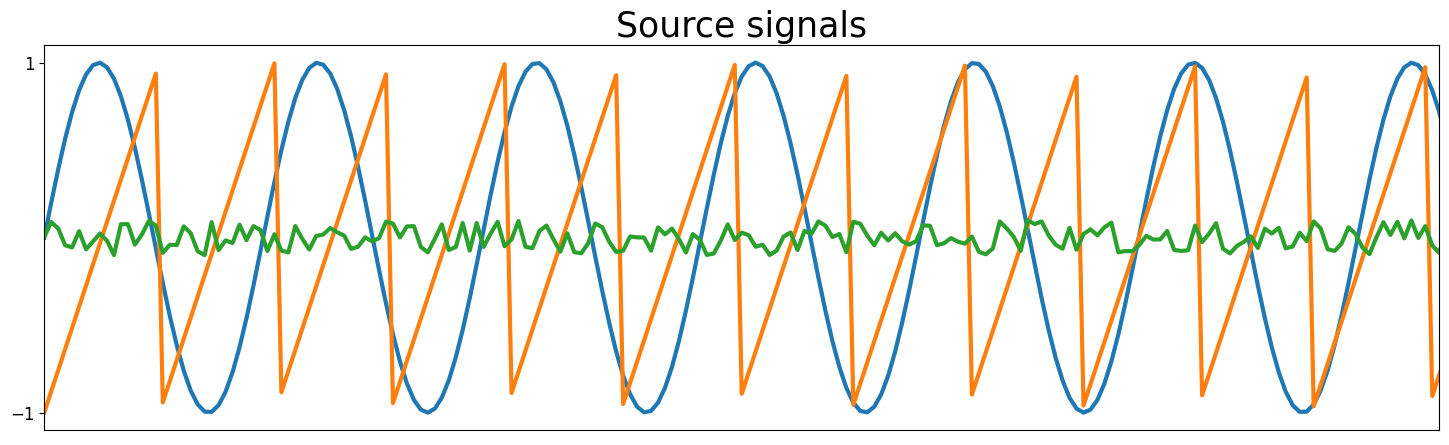

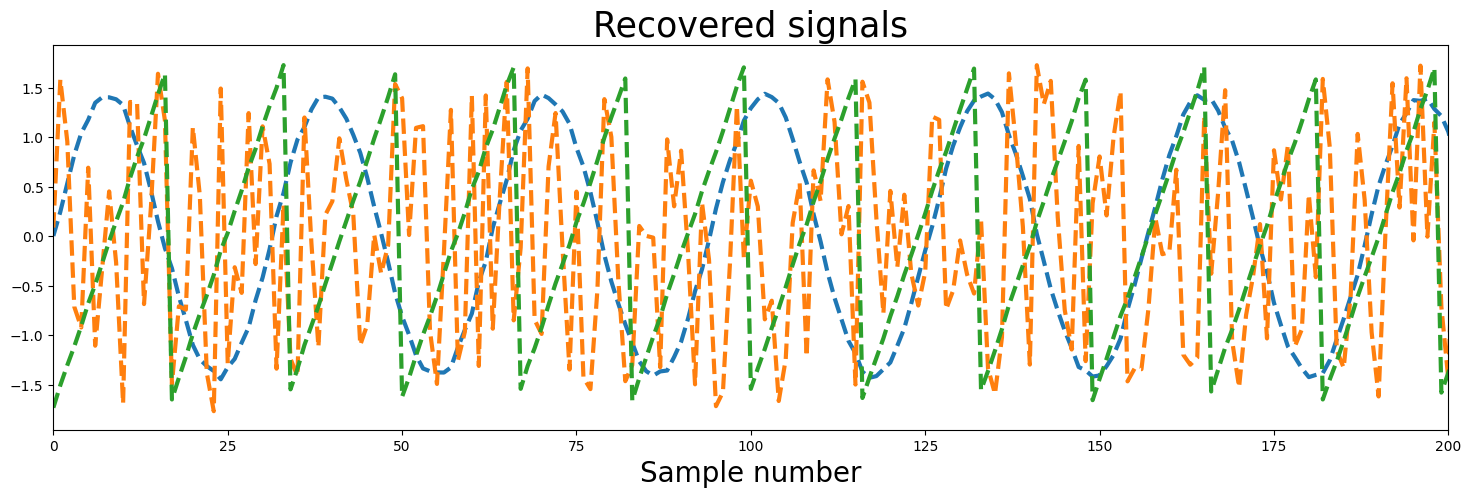

In [130]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=3)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 200)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed, '--', label='Recovered signals', lw=3)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 200)

plt.show()


In [119]:
#> Comparison of matrices involved, A, whiteM, W
# todo...